In [92]:
# --- Sanity check: I/O + Preprocessing ---
import sys
sys.path.append('..')

import matplotlib.pyplot as plt

from harmonizer.io import load_image_rgb
from harmonizer.preprocess import preprocess_for_palette

In [93]:
# ---- 1. Load an image ----
IMG_PATH = "../demo_images/vibrant/vibrant1.jpg" # change to any test image

rgb = load_image_rgb(IMG_PATH)

print("Original RGB:")
print(" shape:", rgb.shape)
print(" dtype:", rgb.dtype)
print(" min/max:", rgb.min(), rgb.max())

Original RGB:
 shape: (2848, 4272, 3)
 dtype: uint8
 min/max: 0 255


In [94]:
# ---- 2. Run preprocessing ----
feats = preprocess_for_palette(
    rgb,
    max_long_edge=640,
    pixel_sample=20000,
    sample_method="grid",   # grid is good for sanity checks
)

print("\nAfter preprocessing:")
print(" resized shape:", feats.rgb_small.shape)
print(" HSV range:",
      f"H[{feats.hsv_small[...,0].min():.1f}, {feats.hsv_small[...,0].max():.1f}]",
      f"S[{feats.hsv_small[...,1].min():.2f}, {feats.hsv_small[...,1].max():.2f}]",
      f"V[{feats.hsv_small[...,2].min():.2f}, {feats.hsv_small[...,2].max():.2f}]")
print(" Lab range:",
      f"L[{feats.lab_small[...,0].min():.1f}, {feats.lab_small[...,0].max():.1f}]",
      f"a[{feats.lab_small[...,1].min():.1f}, {feats.lab_small[...,1].max():.1f}]",
      f"b[{feats.lab_small[...,2].min():.1f}, {feats.lab_small[...,2].max():.1f}]")
print(" # sampled pixels:", len(feats.sample_idx))


After preprocessing:
 resized shape: (426, 640, 3)
 HSV range: H[0.0, 358.0] S[0.00, 1.00] V[0.00, 0.99]
 Lab range: L[0.0, 240.0] a[84.0, 199.0] b[80.0, 206.0]
 # sampled pixels: 20000


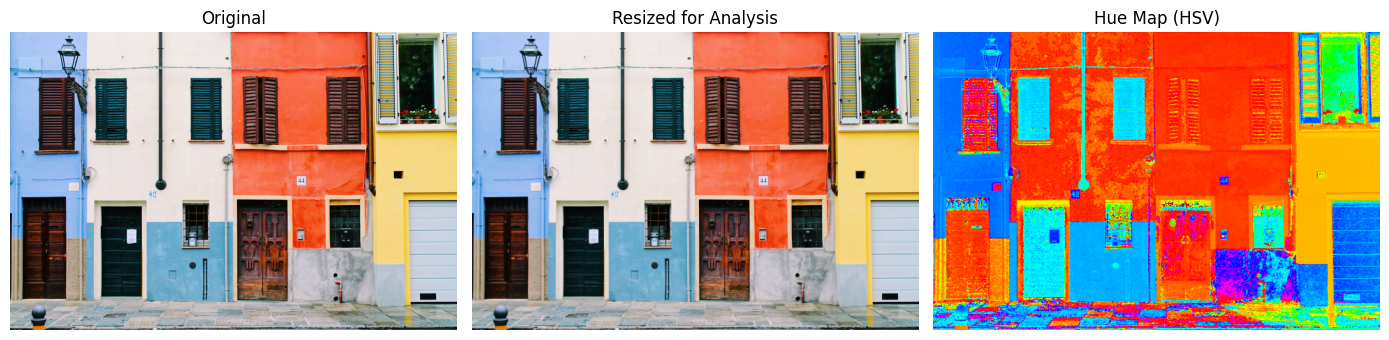

In [95]:
# ---- 3. Visual checks ----
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

# Original
axs[0].imshow(rgb)
axs[0].set_title("Original")
axs[0].axis("off")

# Resized
axs[1].imshow(feats.rgb_small)
axs[1].set_title("Resized for Analysis")
axs[1].axis("off")

# HSV Hue visualization (for intuition)
hue = feats.hsv_small[..., 0] / 360.0  # normalize for colormap
axs[2].imshow(hue, cmap="hsv")
axs[2].set_title("Hue Map (HSV)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

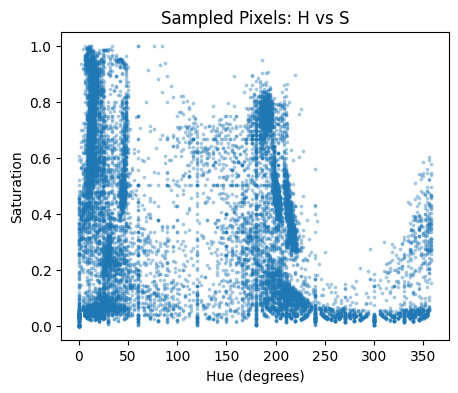


Sanity checks passed if:
- RGB is uint8 with values 0-55
- HSV H≈[0,360), S,V≈[0,1]
- Lab L≈[0,100]
- Hue map visually matches image colors


In [96]:
# ---- 4. Sampling sanity ----
# Plot sampled pixels in HSV space (H vs S)

plt.figure(figsize=(5, 4))
plt.scatter(
    feats.samples_hsv[:, 0],
    feats.samples_hsv[:, 1],
    s=3,
    alpha=0.3
)
plt.xlabel("Hue (degrees)")
plt.ylabel("Saturation")
plt.title("Sampled Pixels: H vs S")
plt.show()

print("\nSanity checks passed if:")
print("- RGB is uint8 with values 0-55")
print("- HSV H≈[0,360), S,V≈[0,1]")
print("- Lab L≈[0,100]")
print("- Hue map visually matches image colors")


In [97]:
import numpy as np
import cv2

from harmonizer.cluster import cluster_colors

In [98]:
# ---- 1. Run clustering ----
res = cluster_colors(
    feats.samples_lab,
    feats.samples_hsv,
    k_candidates=(4, 5, 6),
    seed=42,
    deltaE_merge=6.0,
    min_share=0.015,
)

print("=== CLUSTER SUMMARY ===")
print("Chosen initial K:", res.k_chosen)
print("Final cluster count:", len(res.weights))
print("Weights:", np.round(res.weights, 3))
print("Weights sum:", res.weights.sum())

print("\nHSV Centers (H°, S, V):")
for i, (hsv, w) in enumerate(zip(res.centers_hsv, res.weights)):
    print(f"  Cluster {i}: H={hsv[0]:6.1f}°, S={hsv[1]:.2f}, V={hsv[2]:.2f}, weight={w:.3f}")

print("\nMerge operations:")
print(res.debug["merge"]["merges"] if res.debug["merge"]["merges"] else "  None")

print("\nSilhouette scores by K:")
for k, s in res.debug["k_selection"]["silhouette_scores"].items():
    print(f"  K={k}: {s:.4f}")


=== CLUSTER SUMMARY ===
Chosen initial K: 6
Final cluster count: 6
Weights: [0.234 0.17  0.143 0.287 0.072 0.093]
Weights sum: 1.0

HSV Centers (H°, S, V):
  Cluster 0: H=   8.9°, S=0.07, V=0.91, weight=0.234
  Cluster 1: H= 102.0°, S=0.55, V=0.14, weight=0.170
  Cluster 2: H=  13.4°, S=0.75, V=0.94, weight=0.143
  Cluster 3: H= 210.4°, S=0.24, V=0.78, weight=0.287
  Cluster 4: H=  44.1°, S=0.50, V=0.93, weight=0.072
  Cluster 5: H=  19.3°, S=0.51, V=0.43, weight=0.093

Merge operations:
  None

Silhouette scores by K:
  K=4: 0.5433
  K=5: 0.5262
  K=6: 0.5503


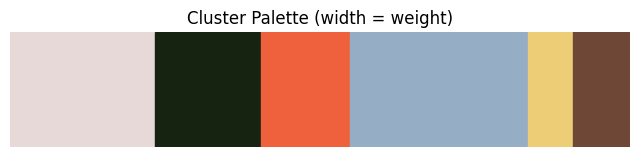

In [99]:


# ---- 2. Visualize palette swatches ----
fig, ax = plt.subplots(figsize=(8, 1.5))
x = 0.0

for hsv, w in zip(res.centers_hsv, res.weights):
    # convert HSV -> RGB for display
    h = hsv[0] / 2.0               # back to OpenCV range
    s = hsv[1] * 255.0
    v = hsv[2] * 255.0
    rgb = np.uint8([[[h, s, v]]])
    rgb = cv2.cvtColor(rgb, cv2.COLOR_HSV2RGB)[0, 0] / 255.0

    ax.add_patch(
        plt.Rectangle((x, 0), w, 1, color=rgb)
    )
    x += w

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")
ax.set_title("Cluster Palette (width = weight)")
plt.show()


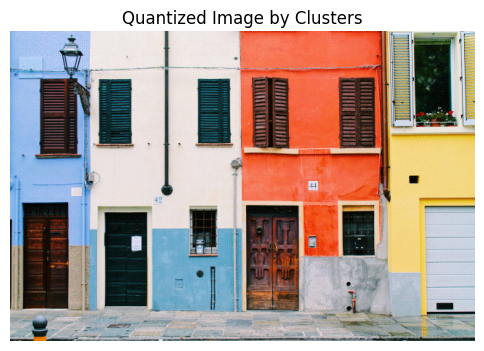


Sanity checks passed if:
- weights sum ≈ 1
- clusters are 3-6 and visually distinct
- quantized image still resembles original


In [100]:

# ---- 3. Quantized preview (optional but powerful) ----
# Assign every sampled pixel to its cluster color and recolor image
H, W = feats.shape_small
quant_rgb = feats.rgb_small.copy().reshape(-1, 3)

# Map each label -> cluster RGB
cluster_rgb = []
for hsv in res.centers_hsv:
    h = hsv[0] / 2.0
    s = hsv[1] * 255.0
    v = hsv[2] * 255.0
    rgb = np.uint8([[[h, s, v]]])
    rgb = cv2.cvtColor(rgb, cv2.COLOR_HSV2RGB)[0, 0]
    cluster_rgb.append(rgb)

cluster_rgb = np.array(cluster_rgb, dtype=np.uint8)

# recolor sampled pixels
quant_rgb[feats.sample_idx] = cluster_rgb[res.labels]

quant_rgb = quant_rgb.reshape(H, W, 3)

plt.figure(figsize=(6, 6))
plt.imshow(quant_rgb)
plt.title("Quantized Image by Clusters")
plt.axis("off")
plt.show()

print("\nSanity checks passed if:")
print("- weights sum ≈ 1")
print("- clusters are 3-6 and visually distinct")
print("- quantized image still resembles original")

In [101]:
from harmonizer.palette import build_palette, find_accent_color

palette = build_palette(res.centers_hsv, res.weights, sort_by="salience")
accent = find_accent_color(palette)

print("=== PALETTE ===")
for i, c in enumerate(palette):
    print(f"{i:>2}: {c.hex}  share={c.share:.3f}  salience={c.salience:.4f}  "
          f"H={c.hsv[0]:.1f} S={c.hsv[1]:.2f} V={c.hsv[2]:.2f}")

print("\nAccent:", accent.hex if accent else None)


=== PALETTE ===
 0: #95ADC5  share=0.287  salience=0.2029  H=210.4 S=0.24 V=0.78
 1: #E7D9D7  share=0.234  salience=0.1623  H=8.9 S=0.07 V=0.91
 2: #EF613D  share=0.143  salience=0.1297  H=13.4 S=0.75 V=0.94
 3: #162310  share=0.170  salience=0.1032  H=102.0 S=0.55 V=0.14
 4: #6E4736  share=0.093  salience=0.0632  H=19.3 S=0.51 V=0.43
 5: #EDCE77  share=0.072  salience=0.0600  H=44.1 S=0.50 V=0.93

Accent: #EF613D


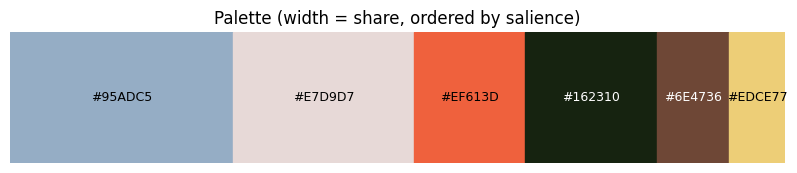

In [102]:

# --- Visualize swatches ---
fig, ax = plt.subplots(figsize=(10, 1.7))
x = 0.0
for c in palette:
    rgb = np.array(c.rgb, dtype=np.float32) / 255.0
    ax.add_patch(plt.Rectangle((x, 0), c.share, 1, color=rgb))
    ax.text(x + c.share/2, 0.5, c.hex, ha="center", va="center",
            fontsize=9, color="white" if (rgb.mean() < 0.5) else "black")
    x += c.share

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")
ax.set_title("Palette (width = share, ordered by salience)")
plt.show()


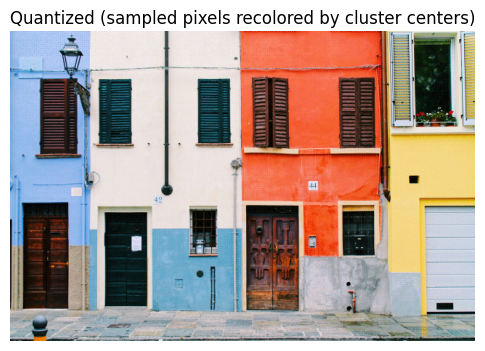


Sanity checks passed if:
- palette shares sum to 1.0 (or very close)
- hex codes look reasonable (not all identical)
- swatches visually match the image vibe


In [103]:

# --- Quick quantized preview using palette colors (labels -> palette order) ---
# Note: palette ordering != label ordering. We'll map each original cluster index to its rgb,
# then recolor sampled pixels.
H, W = feats.shape_small
flat = feats.rgb_small.reshape(-1, 3).copy()

# Build mapping: cluster index -> RGB for that cluster
cluster_rgb = []
for hsv in res.centers_hsv:
    hsv_cv = np.uint8([[[hsv[0]/2.0, hsv[1]*255.0, hsv[2]*255.0]]])
    rgb = cv2.cvtColor(hsv_cv, cv2.COLOR_HSV2RGB)[0, 0]
    cluster_rgb.append(rgb)
cluster_rgb = np.array(cluster_rgb, dtype=np.uint8)

flat[feats.sample_idx] = cluster_rgb[res.labels]
quant = flat.reshape(H, W, 3)

plt.figure(figsize=(6, 6))
plt.imshow(quant)
plt.title("Quantized (sampled pixels recolored by cluster centers)")
plt.axis("off")
plt.show()

print("\nSanity checks passed if:")
print("- palette shares sum to 1.0 (or very close)")
print("- hex codes look reasonable (not all identical)")
print("- swatches visually match the image vibe")


In [104]:
from harmonizer.mood import infer_mood

m = infer_mood(palette, cfg=None)  # or cfg loaded from your YAML

print("=== MOOD ===")
print("Primary:", m.primary)
print("Tags:", m.tags)
print("Scores:", {k: round(v, 3) for k, v in m.scores.items()})
print("\nExplain:")
for e in m.explain[:10]:
    print("-", e)


=== MOOD ===
Primary: vibrant
Tags: []
Scores: {'calming': 0.351, 'energetic': 0.649, 'cozy': 0.635, 'minimal': 0.261, 'dramatic': 0.4, 'pastel': 0.0, 'vibrant': 0.718}

Explain:
- primary=vibrant (scores={'calming': 0.351, 'energetic': 0.649, 'cozy': 0.635, 'minimal': 0.261, 'dramatic': 0.4, 'pastel': 0.0, 'vibrant': 0.718})
- energetic boost: contrast=0.80 >= 0.25
- H_mean=37.1°, H_spread≈128.9°
- S_mean=0.37, V_mean=0.70, neutral_share=0.52
- V_range=0.80, S_range=0.67


=== HARMONIES ===
Base: #95ADC5
Complementary: #C3AA8F
Analogous: ['#8FC2C3', '#908FC3']
Triadic: ['#C38FA9', '#A9C38F']
Split Complementary: ['#C3908F', '#C2C38F']
Explain: ['style=default (ref_s=0.37, ref_v=0.70)', 'base_hsv=(210.4, 0.24, 0.78)', 'comp_h=30.4, analogous=[180.4,240.4], triadic=[330.4,90.4]']


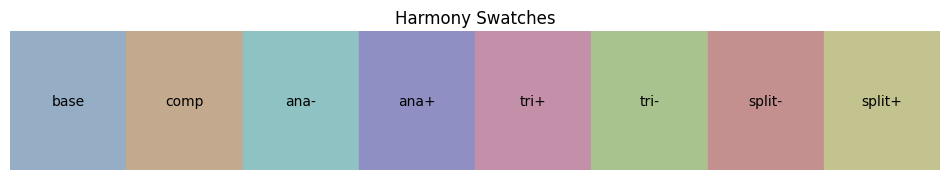

In [105]:
from harmonizer.harmony import generate_harmonies

harm = generate_harmonies(palette)

print("=== HARMONIES ===")
print("Base:", harm.base_hex)
print("Complementary:", harm.complementary)
print("Analogous:", harm.analogous)
print("Triadic:", harm.triadic)
print("Split Complementary:", harm.split_complementary)
print("Explain:", harm.explain)

# Simple swatch display
import numpy as np
import matplotlib.pyplot as plt

def hex_to_rgb01(h):
    h = h.lstrip("#")
    return np.array([int(h[i:i+2], 16) for i in (0,2,4)], dtype=np.float32) / 255.0

swatches = [harm.base_hex, harm.complementary] + harm.analogous + harm.triadic + harm.split_complementary
labels = ["base","comp","ana-","ana+","tri+","tri-","split-","split+"]

fig, ax = plt.subplots(figsize=(12, 1.8))
x = 0
for hx, lab in zip(swatches, labels):
    ax.add_patch(plt.Rectangle((x, 0), 1, 1, color=hex_to_rgb01(hx)))
    ax.text(x + 0.5, 0.5, lab, ha="center", va="center",
            color="white" if hex_to_rgb01(hx).mean() < 0.5 else "black")
    x += 1

ax.set_xlim(0, len(swatches))
ax.set_ylim(0, 1)
ax.axis("off")
ax.set_title("Harmony Swatches")
plt.show()


In [106]:
import yaml
from harmonizer.pipeline import analyze_image

# If you have a YAML config:
# cfg = yaml.safe_load(open("configs/default.yaml"))
cfg = None

result = analyze_image(IMG_PATH, cfg=cfg)

print("Primary mood:", result["mood"]["primary"])
print("Tags:", result["mood"]["tags"])
print("Accent:", result["accent"])
print("Harmony (comp):", result["harmony"]["complementary"])
print("Palette (top 3):", [p["hex"] for p in result["palette"][:3]])
print("Timing:", {k: round(v, 3) for k, v in result["diagnostics"]["timing_sec"].items()})


Primary mood: energetic
Tags: ['warm']
Accent: None
Harmony (comp): #B6D3E1
Palette (top 3): ['#E9CFC4', '#93ADC3', '#E2653F']
Timing: {'io': 0.086, 'preprocess': 0.012, 'cluster': 2.844, 'palette': 0.0, 'mood': 0.0, 'harmony': 0.0, 'total': 2.943}


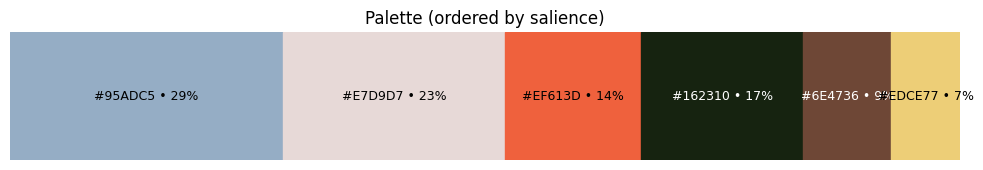

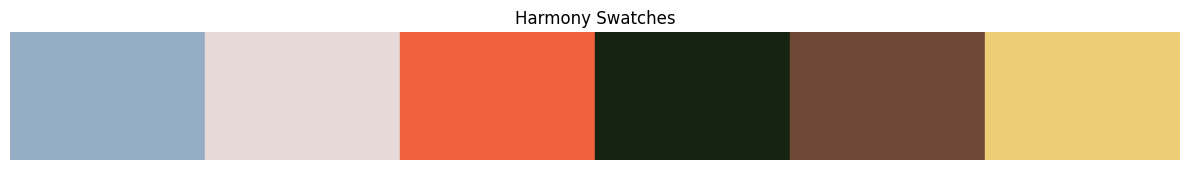

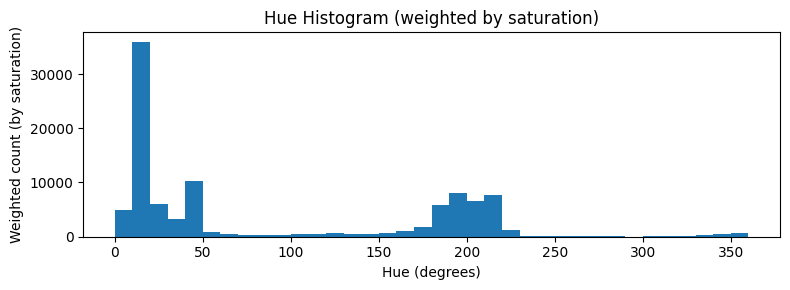

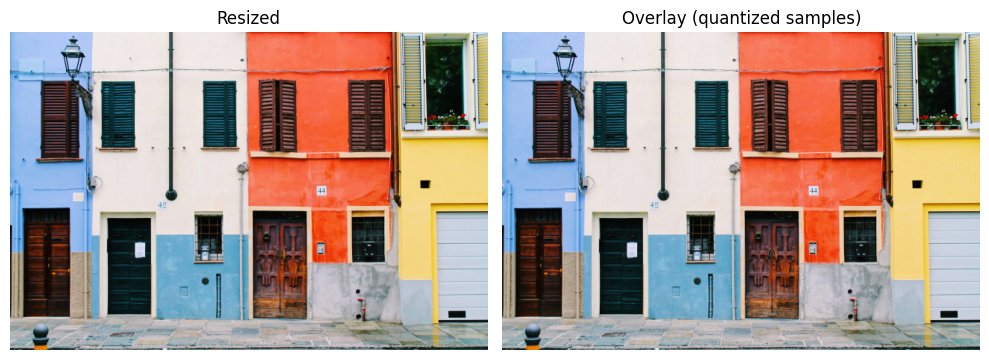

In [107]:
from harmonizer.viz import (
    plot_palette_swatches,
    plot_harmony_swatches,
    plot_hue_histogram,
    quantize_image_by_centers_hsv,
    overlay_quantized,
    show_side_by_side,
)

# 1) Palette bar
fig = plot_palette_swatches(palette, title="Palette (ordered by salience)")
plt.show()

# 2) Harmony swatches
fig = plot_harmony_swatches([c.hex for c in palette], title="Harmony Swatches")
plt.show()

# 3) Hue histogram
fig = plot_hue_histogram(feats.hsv_small, title="Hue Histogram (weighted by saturation)")
plt.show()

# 4) Quantized + overlay
quant = quantize_image_by_centers_hsv(
    feats.rgb_small,
    feats.sample_idx,
    res.labels,
    res.centers_hsv
)
blend = overlay_quantized(feats.rgb_small, quant, alpha=0.65)

fig = show_side_by_side(feats.rgb_small, blend, title_a="Resized", title_b="Overlay (quantized samples)")
plt.show()
